Dataset at: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products/kernels
Aim: Use the textual reviews of Amazon Products to predict ratings, while experimenting various parts of textual analysis.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import bz2
import re
import string
import nltk
from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score

In [2]:
reviews= pd.read_csv('../1429_1.csv')
reviews.columns = ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'date', 'dateAdded', 'dateSeen', 'didPurchase', 'doRecommend', 'id', 'numHelpful', 'rating', 'sourceURLs', 'text', 'title', 'userCity', 'userProvince', 'username']
reviews.head()

C:\Users\saumy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,date,dateAdded,dateSeen,...,doRecommend,id,numHelpful,rating,sourceURLs,text,title,userCity,userProvince,username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


Drop these columns as they would have no effect in the analysis later.

In [33]:
reviews.drop(['id', 'dateSeen', 'sourceURLs', 'userCity', 'userProvince', 'username'], axis = 1, inplace= True)

In [4]:
reviews[['rating', 'title', 'text' ]].isnull().sum()

rating    33
title      5
text       1
dtype: int64

Drop the one review without the text as it has no use in the model

In [5]:
reviews_nna= reviews[pd.notnull(reviews['text'])]
reviews_nna[['rating', 'title', 'text' ]].isnull().sum()

rating    33
title      5
text       0
dtype: int64

Create a new dataframe with the important columns.

In [6]:
sentiment_df= reviews_nna[[ 'asins', 'doRecommend', 'rating', 'title', 'text']]
sentiment_df.head()

,asins,doRecommend,rating,title,text
0,B01AHB9CN2,True,5.0,Kindle,This product so far has not disappointed. My c...
1,B01AHB9CN2,True,5.0,very fast,great for beginner or experienced person. Boug...
2,B01AHB9CN2,True,5.0,Beginner tablet for our 9 year old son.,Inexpensive tablet for him to use and learn on...
3,B01AHB9CN2,True,4.0,Good!!!,I've had my Fire HD 8 two weeks now and I love...
4,B01AHB9CN2,True,5.0,Fantastic Tablet for kids,I bought this for my grand daughter when she c...


Create a new plot that shows the count of reviews across ratings and if the product is recommended by the reviwer.

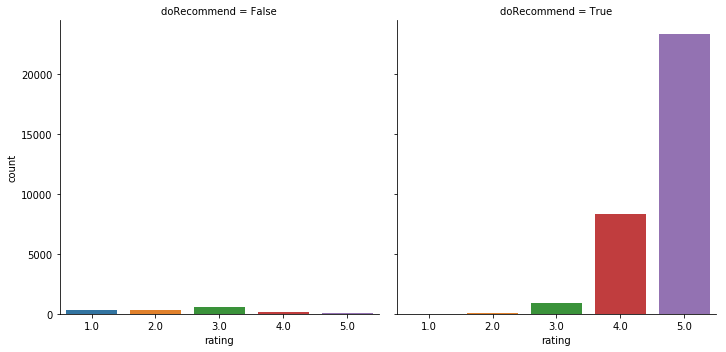

In [7]:
sns.catplot(x= 'rating', col= 'doRecommend', data= sentiment_df, kind= 'count')

In this part, I check two types of stemming methods that are available- Porter and Snowball. So, passed a review to the functions created to generate stemmed equivalents and see the results.
    According to the outputs, the Snowball stemming seems to generate more readable output, while also cleaning up the texts( lower-case and removing special characters). So, I use the Snowball stemming for further use.

In [8]:
from nltk import SnowballStemmer
from nltk import PorterStemmer
from nltk import sent_tokenize, word_tokenize

stopwords = nltk.corpus.stopwords.words('english')

ss = SnowballStemmer('english')
ps= PorterStemmer()

def sentencePorterStem(sentence):
    token_words= word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        if word not in stopwords:
            stem_sentence.append(ps.stem(word))
            stem_sentence.append(' ')
    return ''.join(stem_sentence) 

def sentenceSnowballStem(sentence):
    token_words= word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        if word not in stopwords:
            stem_sentence.append(ss.stem(word))
            stem_sentence.append(' ')
    return ''.join(stem_sentence)

sen= str(sentiment_df['text'][3])

ps_sen= sentencePorterStem(sen)
ss_sen= sentenceSnowballStem(sen)
print(sen)
print('Porter Stem- '+ ps_sen)
print('Snowball Stem- '+ ss_sen)

I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bright infact it is brighter then the ipad pro costing $900 base model. The build on this fire is INSANELY AWESOME running at only 7.7mm thick and the smooth glossy feel on the back it is really amazing to hold its like the futuristic tab in ur hands.
Porter Stem- I 've fire HD 8 two week I love . thi tablet great value.w prime member tablet shine . I love abl easili access prime content well movi download watch laterthi 1280/800 screen realli nice look nice crisp bright infact brighter ipad pro cost $ 900 base model . the build fire insan awesom run 7.7mm thick smooth glossi feel back realli amaz hold like futurist tab ur hand . 
Snowball Stem- i ve

In [9]:
sentiment_df['text_stem']= sentiment_df['text'].apply(sentenceSnowballStem)

C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now, with the stemmed reviews, it is required to create vectorized versions of the text. There are two methods we can go with, count vectorization and TF-IDF vectorization. In this part, I generate the TF-IDF version of the whole review dataset to understand the method and see the output that is generated by it. 
Since TF-IDF and Count vectorization both use similar concepts and generate similar output format, I decided to check the TF-IDF version.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sbstem_vectorizer= TfidfVectorizer()
textfeatures= sbstem_vectorizer.fit_transform(sentiment_df['text_stem'])

Check list of feature names generated by the version. The vocabulary dictionary has the terms which are mapped to the feature indices.

In [32]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print(take(20, sbstem_vectorizer.vocabulary_.items()))

[('this', 9219), ('product', 7190), ('far', 3472), ('disappoint', 2754), ('my', 6081), ('children', 1928), ('love', 5589), ('use', 9771), ('like', 5457), ('abil', 406), ('monitor', 5968), ('control', 2258), ('content', 2242), ('see', 8037), ('eas', 3035), ('great', 4194), ('beginn', 1270), ('experienc', 3377), ('person', 6797), ('bought', 1505)]


In [12]:
pd.DataFrame(textfeatures.toarray()).head(15)

,0,1,2,3,4,5,6,7,8,9,...,10402,10403,10404,10405,10406,10407,10408,10409,10410,10411
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Change the dataframe column names to the terms to make sense of the dataframe. 

In [13]:
text_vect_df= pd.DataFrame(textfeatures.toarray(), columns= sbstem_vectorizer.vocabulary_)
text_vect_df.head(15)

,this,product,far,disappoint,my,children,love,use,like,abil,...,mk,cables,adjac,chargerit,failerd,subsequ,sprint,htc,anth,greedi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Basic sentiment analysis using NLTK.
Using 3 sentences of our own, we use NLTK to identify which sentence are positive, negative or neutral. This can be done by the 'compound' value in the polarity score.

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

pos_sen= 'I am very happy. I absolutely love it. Great job!'
print('positive - '+ str(sia.polarity_scores(pos_sen)))

neg_sen= 'It is so disgusting. I am very angry. I will murder him.'
print('negative - '+ str(sia.polarity_scores(neg_sen)))

neutral_sen= 'I am writing python in jupyter notebook.'
print('negative - '+ str(sia.polarity_scores(neutral_sen)))

positive - {'neg': 0.0, 'neu': 0.272, 'pos': 0.728, 'compound': 0.9372}
negative - {'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.9316}
negative - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


C:\Users\saumy\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [15]:
dataset=sentiment_df[['text_stem', 'rating']]
                     
dataset['rating'] = dataset['rating'].apply(lambda x:'Positive' if x>=4 else 'Negative')

def SentimentCoeff(sentence):
    score = sia.polarity_scores(sentence)
    return score['compound']

dataset['sentiment_coeff']= dataset['text_stem'].apply(SentimentCoeff)
dataset.head()

C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\saumy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,text_stem,rating,sentiment_coeff
0,this product far disappoint . my children love...,Positive,0.6124
1,great beginn experienc person . bought gift love,Positive,0.9042
2,"inexpens tablet use learn , step nabi . he thr...",Positive,0.3612
3,i ve fire hd 8 two week i love . this tablet g...,Positive,0.9790
4,i bought grand daughter come visit . i set use...,Positive,0.9371


In [16]:
x= dataset['text_stem']
y= dataset['rating']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Using TF-IDF and Count vector formats as inputs to the Logistic regression model to check which version provides better output, along with finding the optimal parameters using GridSearchCV.

In [17]:
tfidf_vectorizer= TfidfVectorizer()
x_train_features_tfidf= tfidf_vectorizer.fit_transform(x_train)
x_test_features_tfidf= tfidf_vectorizer.transform(x_test)

count_vectorizer= CountVectorizer()
x_train_features_count= count_vectorizer.fit_transform(x_train)
x_test_features_count= count_vectorizer.transform(x_test)

In [21]:
logreg_params={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

grid_logreg= GridSearchCV(LogisticRegression(solver= 'liblinear'), logreg_params, cv=5)
grid_logreg.fit(x_train_features_count, y_train)

logreg= grid_logreg.best_estimator_

print('Best Penalty:', grid_logreg.best_estimator_.get_params()['penalty'])
print('Best C:', grid_logreg.best_estimator_.get_params()['C'])

c_value= grid_logreg.best_estimator_.get_params()['C']
pen_value= grid_logreg.best_estimator_.get_params()['penalty']

C:\Users\saumy\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\saumy\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best Penalty: l2
Best C: 0.1


In [22]:
logreg=LogisticRegression(C= c_value, penalty= pen_value, solver= 'liblinear')
logreg.fit(x_train_features_count, y_train)
y_pred= logreg.predict(x_test_features_count)

In [23]:
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred, pos_label= 'Positive')))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred, pos_label= 'Positive')))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred, pos_label= 'Positive')))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Recall Score: 0.99
Precision Score: 0.94
F1 Score: 0.97
Accuracy Score: 0.94


Plotting confusion matrix of the predicted and actual values.

Text(0.5,15,'Predicted label')

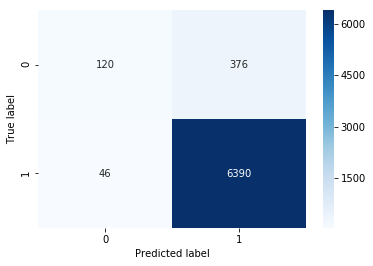

In [24]:
cnf_matrix = confusion_matrix(y_test, y_pred)

df_cnf_matrix= pd.DataFrame(cnf_matrix)
sns.heatmap(df_cnf_matrix, annot=True, fmt='g', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [25]:
logreg_params={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

#Added solver saga to repress warnings- saga recommended by sklearn
grid_logreg= GridSearchCV(LogisticRegression(solver= 'liblinear'), logreg_params, cv=5)
grid_logreg.fit(x_train_features_tfidf, y_train)

logreg= grid_logreg.best_estimator_

print('Best Penalty:', grid_logreg.best_estimator_.get_params()['penalty'])
print('Best C:', grid_logreg.best_estimator_.get_params()['C'])

c_value_tf= grid_logreg.best_estimator_.get_params()['C']
pen_value_tf= grid_logreg.best_estimator_.get_params()['penalty']

Best Penalty: l2
Best C: 10


In [26]:
logreg_tf=LogisticRegression(C= c_value_tf, penalty= pen_value_tf, solver= 'liblinear')
logreg_tf.fit(x_train_features_tfidf, y_train)
y_pred_tf= logreg_tf.predict(x_test_features_tfidf)

In [27]:
print('Recall Score: {:.2f}'.format(recall_score(y_test, y_pred_tf, pos_label= 'Positive')))
print('Precision Score: {:.2f}'.format(precision_score(y_test, y_pred_tf, pos_label= 'Positive')))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred_tf, pos_label= 'Positive')))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred_tf)))

Recall Score: 0.99
Precision Score: 0.95
F1 Score: 0.97
Accuracy Score: 0.94


Text(0.5,15,'Predicted label')

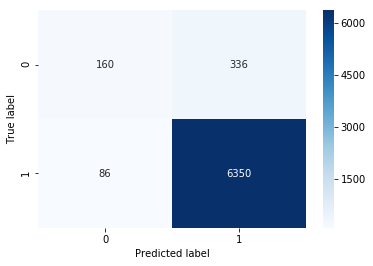

In [28]:
cnf_matrix = confusion_matrix(y_test, y_pred_tf)

df_cnf_matrix= pd.DataFrame(cnf_matrix)
sns.heatmap(df_cnf_matrix, annot=True, fmt='g', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

Overall, it seems that the two versions generate similar results. The F1 scores are the same and they have similar scores for the rest of the parameters. So, for this dataset any vectorization of the text would work well.